In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
tf.__version__

'2.0.0'

## 算法
Adam算法使用了动量变量$v_t$ 和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$s_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$v_t$即小批量随机梯度$g_t$的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t.$$

和RMSProp算法中一样，给定超参数$0\leq\beta_2 <1$（算法作者建议设为0.999）， 将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$s_t$ ：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t.$$

由于我们将$v_0$和$s_0$中的元素都初始化为0， 在时间步$t$我们得到:
$$\boldsymbol{v}_t = (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$$

现在我们将过去所有的时间步的小批量随机梯度的权值相加，得到权值的和为：
$$S_{wv} = (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$$

需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将 $v_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$v_t$和$s_t$均作偏差修正：
$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t},$$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}.$$

接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{v}}_t$和$\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$

其中$eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如 10−8 。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'.$$

In [13]:
def use_svg_display():
    """Use the svg format to display plot in jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    set_figsize((3.5, 2.5))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x, s1, s2 =tf.constant([-5.0, -2.0],shape=(1,2)) , tf.constant([0.0,0.0],shape=(1,2)),tf.constant([0.0,0.0],shape=(1,2))
    results = [tuple( x.numpy()[0])]
    for i in range(20):
        x, s1, s2 = trainer(x, s1, s2,i+1)
        results.append(tuple( x.numpy()[0]))
    print(results)
    print('epoch :',i + 1,'  x: ',tuple( x.numpy()[0]))
    return results

In [14]:
def fx(x1,x2):
    return 0.1 * x1 *x1 + 2 * x2**2

def adam_2d(x,v,s,t):
    dx = tf.constant([0.2,4.0],shape=(1,2)) * x
    v = beta1 * v + (1.0-beta1) * dx
    s = beta2 * s +(1.0-beta2) * dx*dx
    v_hat = v / (1-beta1**t)
    s_hat = s / (1-beta2**t)
    if t == 0:
        print("v_hat:",v_hat," s_hat:",s_hat," v:",v, " s:",s)
    g = eta * v_hat / (tf.sqrt(s_hat) + epsilon)
    return x - g,v,s

[(-5.0, -2.0), (-4.100009, -1.1000011), (-3.2338715, -0.319229), (-2.4287279, 0.21015966), (-1.7116082, 0.40708667), (-1.105459, 0.33194494), (-0.6249711, 0.13504848), (-0.27347782, -0.038565308), (-0.042247593, -0.11025343), (0.08739148, -0.08539289), (0.13992873, -0.021130294), (0.14105558, 0.025838234), (0.11383863, 0.033407584), (0.07631704, 0.014525276), (0.04059336, -0.0055728853), (0.013151068, -0.011885982), (-0.004018612, -0.0061333426), (-0.011926146, 0.0016275682), (-0.013113111, 0.0043117786), (-0.010466054, 0.0021252828), (-0.006440119, -0.000800302)]
epoch : 20   x:  (-0.006440119, -0.000800302)


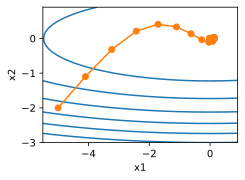

In [21]:
beta1,beta2 = 0.5,0.999
eta,epsilon = 0.9,1e-5
show_trace_2d(fx,train_2d(adam_2d))

In [22]:
def fx(x):
    w = tf.constant([4,-3],dtype=tf.float32)
    
    return tf.reduce_sum(x*w,axis=1)+5.0 + tf.random.normal(shape=(x.shape[0],))

x = tf.random.normal(shape=(1000,2))
y = fx(x)

def create_ds(x,y,batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    return ds.shuffle(1000).batch(batch_size).repeat()

ds = create_ds(x,y,20)

temp_x,temp_y = next(iter(ds))

In [23]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(MyLayer,self).__init__(**kwargs)
        self.w = self.add_weight(name="w",shape=(1,2),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
        self.b = self.add_weight(name="b",shape=(1,),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
    
    def call(self,x):
        return tf.reduce_sum(x * self.w,axis=1,name="sum") + self.b



In [31]:
model = tf.keras.Sequential([
    MyLayer()
])
model.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.9,beta_2=0.999,))
history = model.fit(ds,epochs=5,steps_per_epoch=100,verbose=0)
model.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 4.0114846, -2.9655764]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([5.0166354], dtype=float32)>]

In [32]:
model = tf.keras.Sequential([
    MyLayer()
])
model.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.5,beta_1=0.9,beta_2=0.999,))
history = model.fit(ds,epochs=5,steps_per_epoch=100,verbose=0)
model.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 4.4276123, -2.8938437]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([5.0378146], dtype=float32)>]

In [33]:
model = tf.keras.Sequential([
    MyLayer()
])
model.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.5,beta_1=0.5,beta_2=0.999,))
history = model.fit(ds,epochs=5,steps_per_epoch=100,verbose=0)
model.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 3.6866465, -2.8937318]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([4.9622416], dtype=float32)>]

In [34]:
model = tf.keras.Sequential([
    MyLayer()
])
model.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.5,beta_1=0.9,beta_2=0.5,))
history = model.fit(ds,epochs=5,steps_per_epoch=100,verbose=0)
model.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 3.6740274, -3.124659 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([5.6094265], dtype=float32)>]